# 1. Image Verification

In [2]:
from QSAR_CNN.Imageverification import Image_verification
image_verify = Image_verification(data_dir='./Data/png_2D_ALK_classification/')
image_verify.fit()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All images are readable


In [2]:
data_dir_list = image_verify.dir_list

# 2. Data loader

Found 1197 files belonging to 2 classes.
Found 134 files belonging to 2 classes.
Found 333 files belonging to 2 classes.
Found 1197 files belonging to 2 classes.
Data train samples


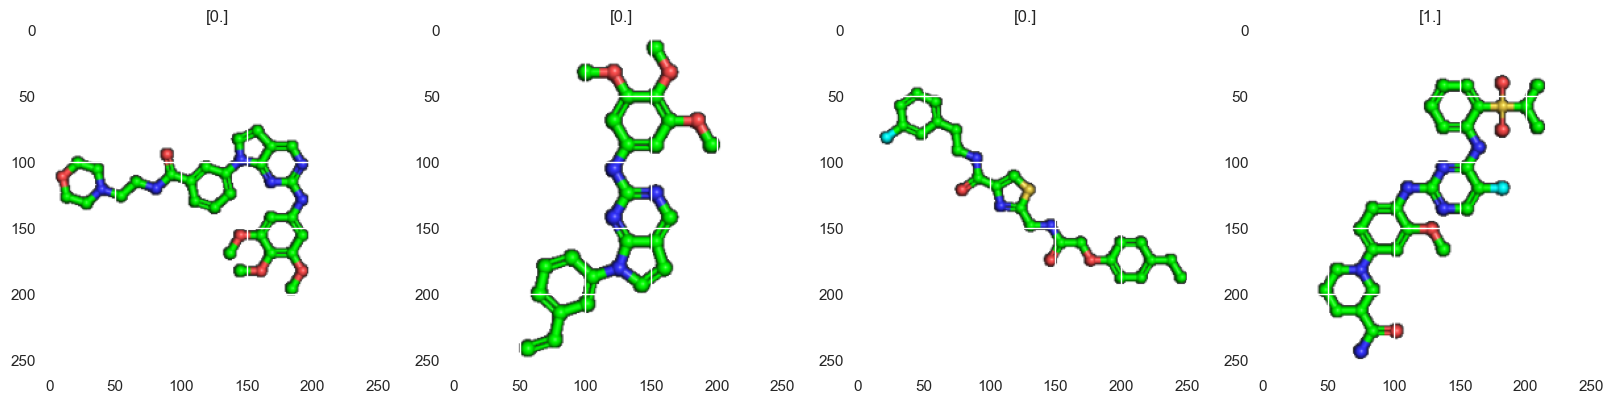

In [3]:
from QSAR_CNN.Data_loader import Data_loader
loader = Data_loader(data_train_dir=data_dir_list[0], data_val_dir=data_dir_list[1], data_test_dir=data_dir_list[2], 
                     batch_size=32, random_seed=42)
loader.fit()

In [4]:
data_train= loader.data_train
data_test= loader.data_test
data_val= loader.data_val

# 3. Rescale Images

In [5]:
data_train = data_train.map(lambda x,y: (x/255, y))
data_val = data_val.map(lambda x,y: (x/255, y))
data_test = data_test.map(lambda x,y: (x/255, y))

# 4. CNN model

## 4.1. Create model

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
from QSAR_CNN.CNN_architecture import CNN_network, step_decay
net = CNN_network(node_layer1=2048,node_layer2=256, input_dim=(256, 256, 3),loss =tf.losses.BinaryCrossentropy(), optim = 'Adam',
                 learning_rate= 0.0001, weight_decay=0.01, regu_l2=0.00, node_out=1, 
                  out_activation='sigmoid', drop_out=0.0, batch_norm=False, 
                  noise=False, noise_values= 0.05, metrics=['accuracy', 
                                        tfa.metrics.FBetaScore(num_classes=2,average='micro',threshold=0.5),
                                        tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model = net.generate_model()

c:\Users\Admin\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Using TensorFlow backend


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
mc = ModelCheckpoint('./Model_2D/best_model.h5', monitor='val_loss', mode='min', verbose=0,
    save_best_only=True)
lrate = LearningRateScheduler(step_decay)
callback_list = [es, mc]
hist = model.fit(data_train, epochs=epochs, validation_data=data_val
                , verbose=1, callbacks=callback_list)

Epoch 1/200


38/38 [==============================] - 14s 76ms/step - loss: 0.6195 - accuracy: 0.6984 - fbeta_score: 0.0424 - precision: 0.2500 - recall: 0.0232 - val_loss: 0.6056 - val_accuracy: 0.7090 - val_fbeta_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
38/38 [==============================] - 3s 65ms/step - loss: 0.5846 - accuracy: 0.7118 - fbeta_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5573 - val_accuracy: 0.7090 - val_fbeta_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
38/38 [==============================] - 2s 63ms/step - loss: 0.5355 - accuracy: 0.7435 - fbeta_score: 0.2108 - precision: 0.9318 - recall: 0.1188 - val_loss: 0.4741 - val_accuracy: 0.7761 - val_fbeta_score: 0.4000 - val_precision: 0.9091 - val_recall: 0.2564
Epoch 4/200
38/38 [==============================] - 2s 56ms/step - loss: 0.4758 - accuracy: 0.7911 - fbeta_score: 0.4980 - precision: 0.8105 - recall: 0.3594 

<Axes: title={'center': 'Recall'}>

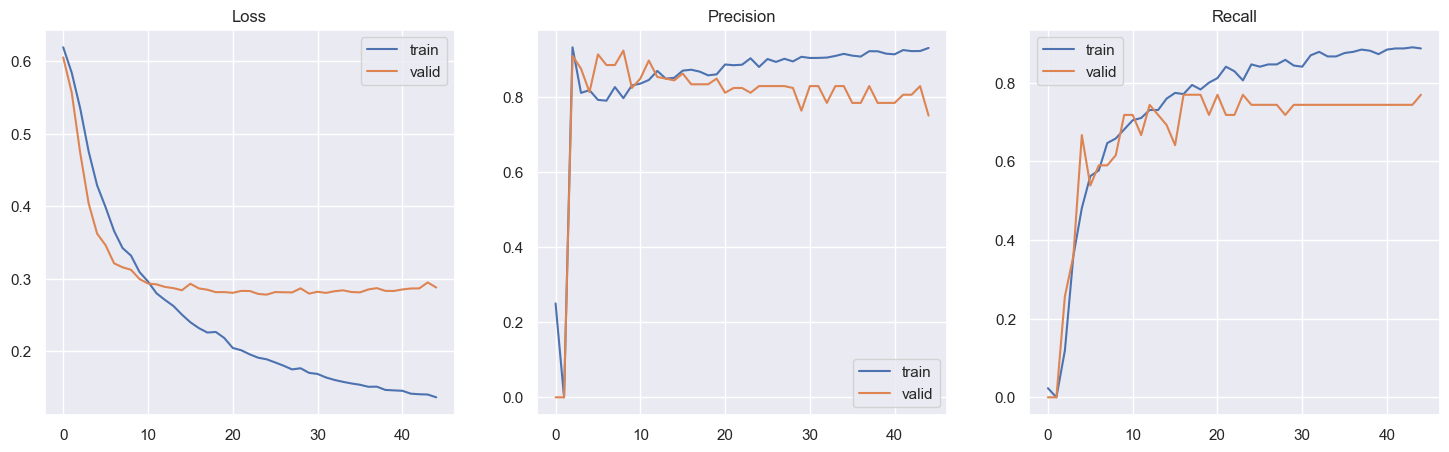

In [18]:
# plot loss learning curves
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.lineplot(data=hist.history['loss'], label='train', ax=axes[0]).set(title='Loss')
sns.lineplot(data=hist.history['val_loss'], label='valid', ax=axes[0])
# plot precision learning curves
sns.lineplot(data=hist.history[list(hist.history.keys())[3]], label='train', ax=axes[1]).set(title='Precision')
sns.lineplot(data=hist.history[list(hist.history.keys())[8]], label='valid', ax=axes[1])
# plot recall learning curves
sns.lineplot(data=hist.history[list(hist.history.keys())[4]], label='train', ax=axes[2]).set(title='Recall')
sns.lineplot(data=hist.history[list(hist.history.keys())[9]], label='valid', ax=axes[2])

## 4.2. Save and load model

In [7]:
from tensorflow.keras.models import load_model
import os
# model.save(os.path.join('models_2D','imageclassifier.h5'))
model = load_model('./Model_2D/best_model.h5')

## 4.3. Evaluate model

### 4.3.1. External validation

In [8]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
import warnings
warnings.filterwarnings("ignore")
for batch in data_test.as_numpy_iterator(): 
    X, y_true = batch
    predY = model.predict(X)
    pre.update_state(y_true, predY)
    re.update_state(y_true, predY)
    acc.update_state(y_true, predY)
print('>Precision:', pre.result())
print('>Recall:', re.result())
print('>F1 score:',  2*pre.result()*re.result()/(pre.result()+re.result()))
print('>BinaryAccuracy:', acc.result())

1/1 [==============================] - 0s 361ms/step
>Precision: tf.Tensor(0.7263158, shape=(), dtype=float32)
>Recall: tf.Tensor(0.71875, shape=(), dtype=float32)
>F1 score: tf.Tensor(0.72251314, shape=(), dtype=float32)
>BinaryAccuracy: tf.Tensor(0.8408408, shape=(), dtype=float32)


### 4.3.2. Internal Validation

In [18]:
loader = Data_loader(data_train_dir=data_dir_list[0], data_val_dir=data_dir_list[1], data_test_dir=data_dir_list[2], 
                     batch_size=1, random_seed=42)
data = loader.load_dataset(data='.\Data\pnd_2D_full')

Found 1664 files belonging to 2 classes.


In [19]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])
np.concatenate((a, b.T), axis=1)

array([[1, 2, 5],
       [3, 4, 6]])

In [28]:
for X, y in data.take(1):
    print(X[0].shape)

(256, 256, 3)


In [35]:
X_array = []
y_array = []
for X, y in data:
    X_array.append(X)
    y_array.append(y)

In [50]:
X_array[0].shape

TensorShape([1, 256, 256, 3])

In [54]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import tensorflow as tf
# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
pre = []
re = []
acc = []
kfold.split(X_array, y_array)


<generator object _RepeatedSplits.split at 0x00000153A37C62E0>

In [ ]:
from sklearn.model_selection import RepeatedKFold

# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# 2. split into input (X) and output (Y) variables
data = pd.concat([data_train_scale, data_test_scale], axis=0)

X = np.array(data.drop(['chembl_id','pIC50'], axis=1))
y = np.array(data['pIC50'])
# 3. define 3-fold cross validation test harness
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
pre = []
re = []
acc = []


for train, test in kfold.split(X, y):

    # create model
    net = neural_net(node_layer1=2048,node_layer2=128, input_dim=1022,loss ='mean_squared_error', optim = 'Adam',
                 learning_rate= 0.0001, weight_decay=0.00, regu_l2=0.00, node_out=1, 
                  out_activation='linear', drop_out=0.0, batch_norm=False, 
                  noise=False, noise_values= 0.05, metrics=[tfa.metrics.RSquare(),'mse', 'mae'])
    model = net.generate_model()
    
    # Compile model
    opt = Adam(learning_rate=0.0001, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer = opt, metrics=[tfa.metrics.RSquare(),'mse', 'mae'])
    
    # Fit the model
    
    history = model.fit(X[train], y[train], epochs = 200, batch_size = 64, verbose = 0)

  # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose = 0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]))
    r2.append(scores[1])
    mse.append(scores[2])
    mae.append(scores[3])

print(">R2-IV %.3f%% ± %.3f%%" % (np.mean(r2), np.std(r2)))
print(">MSE-IV %.3f%% ± %.3f%%" % (np.mean(mse), np.std(mse)))
print(">MAE-IV %.3f%% ± %.3f%%" % (np.mean(mae), np.std(mae)))

record = {"MAE_score": mae,
         "MSE_score": mse,
         "R2": r2}
record_ANN_IV = pd.DataFrame(record)
record_ANN_IV.to_csv("./Data/ANN_IV.csv", index=False)

## Check

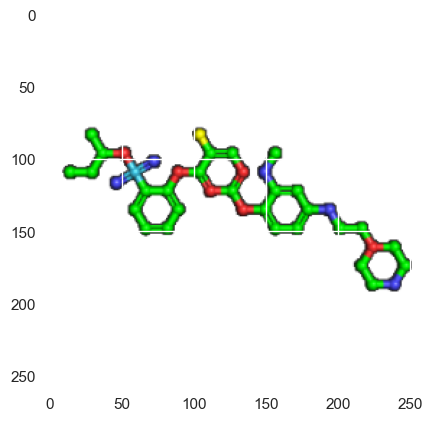

In [23]:
import cv2
img = cv2.imread('./Data/png_2D_ALK_classification/test/1/active_20.png')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [24]:
import numpy as np
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 28ms/step


array([[0.950304]], dtype=float32)